In [2]:
import random
from pathlib import Path
import numpy as np
import copy
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt 
import time

# 實驗

In [3]:
factors_list = ['job','shape_beta','scale_eta']
type_list = ['H','L']
folder_name = "testdata/"
run_time = 600

In [ ]:
# 讀取同規模的測資
for scenario in factors_list:
    for type in type_list:
# for scenario in ['job']:
#     for type in ['H']:
        # 定義路徑及檔名
        prefix = scenario + '_' + type # problem 編號
        result_path = "result/"
        Path(result_path).mkdir(parents=True, exist_ok=True)
        df = {}
        methods = ['PM interval','greedy','quadratic model','piecewise model']
        for mothod in methods:
            df[mothod] = pd.DataFrame(columns=['factor', 'type', 'index', 'time', 'maintenance_schedule', 'objectives'])
        for index in range(1,21):  
            f = open(folder_name + prefix + "/" + prefix + '_' + str(index) + ".txt", "r")
            first_line = f.readline().split()

            #=================== 資料部分 ===================#
            shape_beta = int(first_line[0])
            scale_eta = int(first_line[1])
            n = int(first_line[2])
            
            second_line = f.readline().split()
            initial_age = int(second_line[0])
            cm_time = int(second_line[1])
            pm_time = int(second_line[2])
            
            weight = []
            processing_time = []
            for j in range(n):
                line = f.readline().split()
                weight.append(int(line[0]))
                processing_time.append(int(line[1]))
            f.close()
            
            #=================== 排工作 ===================#
            # ＷＳPT alg

            ratio = {}
            for i in range(n):
                ratio[i+1] = weight[i]/processing_time[i]
            print('ratio:', ratio)

            sort_ratio = dict(sorted(ratio.items(), key=lambda item: item[1],reverse=True))
            print('sort_ratio:', sort_ratio)

            job_sequence = list(sort_ratio.keys())
            print('job_sequence:', job_sequence)

            # 根據 ＷＳPT 的工作排序設定 x_ij
            x_wstp = {}
            for i in range(n):
                for j in range(n):
                    if job_sequence[i] == j+1:
                        x_wstp[i,j] = 1
                    else:
                        x_wstp[i,j] = 0
            # print result
            print('WSPT 工作排序：')
            for i in range(n):
                for j in range(n):
                    if x_wstp[i,j] == 1:
                        print('第 ' + str(i+1) + ' 個做 job ' + str(j+1))
                        
            #=================== 排維修 ===================#
            for mothod in methods:
                
                ## weight of the i th job
                w_i = {}
                for i in range(n):
                    w_i[i] = quicksum(weight[j]*x_wstp[i,j] for j in range(n)).getValue()

                ## processing time of the i th job
                p_i = {}
                for i in range(n):
                    p_i[i] = quicksum(processing_time[j]*x_wstp[i,j] for j in range(n)).getValue()

                # 最大機齡
                a_max = 100
                
                if mothod == 'PM interval':
                    #=================== PM interval ===================#
                    print('1. PM interval')
                    org_time = time.time()
                    optimal_pm_interval = scale_eta*(pm_time/(cm_time*(shape_beta-1)))**(1/shape_beta)
                    print('optimal_pm_interval',optimal_pm_interval)
                    y = {}
                    total_weight = 0
                    competion_t = {}
                    age_after_pm = {}
                    age_now = {}  
                    for i,job in enumerate(job_sequence):
                        job_index = job - 1
                        if i == 0:
                            if initial_age > optimal_pm_interval:
                                y[i] = 1
                                age_after_pm[i] = 1
                            else:
                                y[i] = 0
                                age_after_pm[i] = initial_age
                        else:
                            if age_now[i-1] > optimal_pm_interval:
                                y[i] = 1
                                age_after_pm[i] = 1
                            else:
                                y[i] = 0
                                age_after_pm[i] = age_now[i-1]

                        age_now[i] = age_after_pm[i] + p_i[i]


                        if i == 0:
                            competion_t[i] = p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                        else:
                            competion_t[i] = competion_t[i-1] + p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                        total_weight += competion_t[i]*w_i[i]
                    print('維修結果：')
                    for i in range(n):
                        print(y[i])
                    print('Obj 結果：')
                    print('total_weight',total_weight)
                    df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index':index, 'time': float(time.time() - org_time), 'maintenance_schedule': y.values(), 'objectives': total_weight},ignore_index=True)
                elif mothod == 'greedy':
                    #=================== greedy ===================#
                    print('2. greedy')

                    from itertools import product
                    if n == 3:
                        y_list = list(product((0,1), (0,1), (0,1)))
                    elif n == 5:
                        y_list = list(product((0,1), (0,1), (0,1), (0,1), (0,1)))
                    elif n == 10:
                        y_list = list(product((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1)))

                    # 計算 objective value 
                    min_obj = 10000000
                    min_main = [0,0,0]
                    for y in y_list:
#                         print(y)
                        total_weight = 0
                        competion_t = {}
                        age_after_pm = {}
                        age_now = {}  
                        for i,job in enumerate(job_sequence):
                            job_index = job - 1
                            if y[i] == 1:
                                age_after_pm[i] = 1
                            elif i == 0:
                                age_after_pm[i] = initial_age
                            else:
                                age_after_pm[i] = age_now[i-1]

                            age_now[i] = age_after_pm[i] + p_i[i]


                            if i == 0:
                                competion_t[i] = p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                            else:
                                competion_t[i] = competion_t[i-1] + p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                            total_weight += competion_t[i]*w_i[i]

                        if min_obj > total_weight:
                            min_obj = total_weight
                            min_main = y
                            min_age_after_pm = age_after_pm
                            min_age_now = age_now
                    print('維修結果：')
                    for i in range(n):
                        print(min_main[i])
                    print('Obj 結果：')
                    print('total_weight',min_obj)
                    df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index':index, 'maintenance_schedule': min_main, 'time': float(time.time() - org_time),'objectives': min_obj},ignore_index=True)
                elif mothod == 'quadratic model' and shape_beta ==2:
                    #=================== quadratic model ===================#
                    print('3. quadratic stochastic model')

                    # 建立模型
                    model = Model("model")  # build a new model, name it as "model"

                    # 設定時間及 gap
                    model.params.NonConvex = shape_beta
                    model.Params.TimeLimit = 600  # 30 minutes

                    # 定義決策變數

                    ## maintenance before the i th position or not
                    y_i = model.addVars(n, vtype=GRB.BINARY)

                    ## the age of machine on the i th position after decide PM
                    a_before = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

                    ## the age of machine on the i th position before decide PM
                    a_after = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

                    ## the expected completion time of machine on the i th position
                    e_i = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0)

                    # 定義目標變數

                    model.setObjective((quicksum(w_i[i]*e_i[i] for i in range(n))), GRB.MINIMIZE)

                    # 定義限制式

                    # define the completion time of each position
                    model.addConstr((e_i[0] == (pm_time*y_i[0] + p_i[0] + \
                                                cm_time*((a_after[0]/scale_eta)**shape_beta - (a_before[0]/scale_eta)**shape_beta))
                                    ), "Define first expected completion time")
                    model.addConstrs(((e_i[i] == e_i[i-1] + (pm_time*y_i[i] + p_i[i] + \
                                                             cm_time*((a_after[i]/scale_eta)**shape_beta - (a_before[i]/scale_eta)**shape_beta))
                                     )for i in range(1,n)), "Define expected completion time")

                    # define the a_after and a_before of each position
                    M = 100
                    model.addConstrs((a_before[i] >= a_after[i-1]-M*y_i[i] for i in range(1,n)), "Define a_before")
                    model.addConstr((a_before[0] >= initial_age-M*y_i[0]), "Define initial a_before")
                    model.addConstrs((a_after[i] == a_before[i] + p_i[i] for i in range(n)), "Define a_after")

                    # run Gurobi
                    model.optimize()

                    # print result
                    print('維修結果：')
                    main = []
                    for i in range(n):
                        print(y_i[i].x)
                        main.append(y_i[i].x)
                    obj = model.objVal
#                     obj = cal_obj(w_i,y_i,scale_eta,shape_beta)
                    print('obj 結果：',obj)
                    df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index': index, 'maintenance_schedule': main, 'time': float(time.time() - org_time), 'objectives': obj},ignore_index=True)
                
                elif mothod == 'piecewise model':
                    #=================== piecewise model ===================#
                    print('4. piecewise stochastic model')
                    # 最大機齡
                    a_max = 100
                    lb = 1
                    # 切段
                    m = 100

                    x = []
                    x_beta = []  # a_i 線段後的點 x
                    for j in np.linspace(lb, a_max, num=m):
                        x.append(j)
                        x_beta.append(j**shape_beta)

                    slope_s = []  # a_i 的斜率
                    for j in range(0, m-1):
                        slope_s.append((x_beta[j+1] - x_beta[j]) / (x[j+1] - x[j]))

                    # 建立模型 : piecewise
                    model = Model("model")  # build a new model, name it as "model"

                    # 設定時間及 gap
                    # model.Params.MIPGap = mipgap    # 1%
                    model.Params.TimeLimit = run_time  # 30 minutes

                    # 定義決策變數

                    ## maintenance before the i th position or not
                    y_i = model.addVars(n, vtype=GRB.BINARY)

                    ## the age of machine on the i th position after decide PM
                    a_before = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

                    ## the age of machine on the i th position before decide PM
                    a_after = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

                    ## the expected completion time of machine on the i th position
                    e_i = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0)


                    ## peicewise linearize
                    u = model.addVars(n, m, lb=0.0, ub=1.0, vtype=GRB.BINARY, name="u")
                    w = model.addVars(n, m, lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="w")
                    u_bar = model.addVars(n, m, lb=0.0, ub=1.0, vtype=GRB.BINARY, name="u_bar")
                    w_bar = model.addVars(n, m, lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="w_bar")

                    # 定義目標變數

                    model.setObjective((quicksum(w_i[i]*e_i[i] for i in range(n))), GRB.MINIMIZE)

                    # 定義限制式

                    # define the completion time of each position
                    model.addConstr((e_i[0] == 
                                     pm_time * y_i[0] + p_i[0] + \
                                     cm_time *
                                     (
                                         (x_beta[0] + slope_s[0] * (a_after[0] - x[0]) + \
                                          quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u[0,j] + a_after[0] - x[j] - w[0,j]) for j in range(1, m-1))) - \
                                         (x_beta[0] + slope_s[0] * (a_before[0] - x[0]) + \
                                          quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u_bar[0,j] + a_before[0] - x[j] - w_bar[0,j]) for j in range(1, m-1)))
                                     )/(scale_eta**shape_beta)
                                    ), "Define first expected completion time")
                    model.addConstrs(((e_i[i] == e_i[i-1] + \
                                       pm_time * y_i[i] + p_i[i] + \
                                       cm_time *
                                       (
                                           (x_beta[0] + slope_s[0] * (a_after[i] - x[0]) + \
                                            quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u[i,j] + a_after[i] - x[j] - w[i,j]) for j in range(1, m-1))) - \
                                          (x_beta[0] + slope_s[0] * (a_before[i] - x[0]) + \
                                            quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u_bar[i,j] + a_before[i] - x[j] - w_bar[i,j]) for j in range(1, m-1)))
                                        )/(scale_eta**shape_beta)
                                     ) for i in range(1,n)), "Define expected completion time")

                    # define the a_after and a_before of each position
                    M = 100
                    model.addConstrs((a_before[i] >= a_after[i-1] - M*y_i[i] for i in range(1,n)), "Define a_before")
                    model.addConstr((a_before[0] >= initial_age - M*y_i[0]), "Define initial a_before")
                    model.addConstrs((a_after[i] == a_before[i] + p_i[i] for i in range(n)), "Define a_after")

                    # constraints for a_after term
                    model.addConstrs(-x[m-1] * u[i,j] <= a_after[i] - x[j] for j in range(1, m) for i in range(n))
                    model.addConstrs(a_after[i] - x[j] <= x[m-1] * (1 - u[i,j]) for j in range(1, m) for i in range(n))
                    model.addConstrs(-x[m-1] * u[i,j] <= w[i,j] for j in range(1, m) for i in range(n))
                    model.addConstrs(w[i,j] <= x[m-1] * u[i,j] for j in range(1, m) for i in range(n))
                    model.addConstrs(x[m-1] * (u[i,j] - 1) + a_after[i] <= w[i,j] for j in range(1, m) for i in range(n))
                    model.addConstrs(w[i,j] <= x[m-1] * (1 - u[i,j]) + a_after[i] for j in range(1, m) for i in range(n))
                    model.addConstrs(u[i,j] >= u[i,j-1] for j in range(1, m) for i in range(n))

                    # # constraints for a_before term
                    model.addConstrs(-x[m-1] * u_bar[i,j] <= a_before[i] - x[j] for j in range(1, m) for i in range(n))
                    model.addConstrs(a_before[i] - x[j] <= x[m-1] * (1 - u_bar[i,j]) for j in range(1, m) for i in range(n))
                    model.addConstrs(-x[m-1] * u_bar[i,j] <= w_bar[i,j] for j in range(1, m) for i in range(n))
                    model.addConstrs(w_bar[i,j] <= x[m-1] * u_bar[i,j] for j in range(1, m) for i in range(n))
                    model.addConstrs(x[m-1] * (u_bar[i,j] - 1) + a_before[i] <= w_bar[i,j] for j in range(1, m) for i in range(n))
                    model.addConstrs(w_bar[i,j] <= x[m-1] * (1 - u_bar[i,j]) + a_before[i] for j in range(1, m) for i in range(n))
                    model.addConstrs(u_bar[i,j] >= u_bar[i,j-1] for j in range(1, m) for i in range(n))
                    # run Gurobi
                    model.optimize()

                    # print result
                    print('維修結果：')
                    main = []
                    for i in range(n):
                        print(y_i[i].x)
                        main.append(y_i[i].x)
#                     obj = cal_obj(w_i,y_i,scale_eta,shape_beta)
                    obj = model.objVal
                    print('Obj 結果：',obj)
                    
                    df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index':index, 'time': float(time.time() - org_time), 'maintenance_schedule':main, 'objectives': obj},ignore_index=True)
            print('=======================================')
        with pd.ExcelWriter(result_path  + prefix + ".xlsx", engine="openpyxl", mode='w') as writer:
            for mothod in methods:
                df[mothod].to_excel(writer,sheet_name=mothod)

ratio: {1: 0.10204081632653061, 2: 0.3333333333333333, 3: 0.22727272727272727}
sort_ratio: {2: 0.3333333333333333, 3: 0.22727272727272727, 1: 0.10204081632653061}
job_sequence: [2, 3, 1]
WSPT 工作排序：
第 1 個做 job 2
第 2 個做 job 3
第 3 個做 job 1
1. PM interval
optimal_pm_interval 29.240177382128664
維修結果：
1
0
0
Obj 結果：
total_weight 607.8923199999999
2. greedy
維修結果：
1
0
1
Obj 結果：
total_weight 562.03232
4. piecewise stochastic model
Academic license - for non-commercial use only - expires 2021-07-26
Using license file /Users/janeliao/gurobi.lic
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4167 rows, 1212 columns and 10708 nonzeros
Model fingerprint: 0x03dd8e95
Variable types: 609 continuous, 603 integer (603 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [1e+00, 

In [ ]:
scenario = 'benchmark'
# 定義路徑及檔名
prefix = scenario # problem 編號
result_path = "result/"
Path(result_path).mkdir(parents=True, exist_ok=True)
df = {}
methods = ['PM interval','greedy','quadratic model','piecewise model']
for mothod in methods:
    df[mothod] = pd.DataFrame(columns=['factor', 'type', 'index', 'time', 'maintenance_schedule', 'objectives'])
for index in range(1,21):  
    f = open(folder_name + prefix + "/" + prefix + '_' + str(index) + ".txt", "r")
    first_line = f.readline().split()

    #=================== 資料部分 ===================#
    shape_beta = int(first_line[0])
    scale_eta = int(first_line[1])
    n = int(first_line[2])

    second_line = f.readline().split()
    initial_age = int(second_line[0])
    cm_time = int(second_line[1])
    pm_time = int(second_line[2])

    weight = []
    processing_time = []
    for j in range(n):
        line = f.readline().split()
        weight.append(int(line[0]))
        processing_time.append(int(line[1]))
    f.close()

    #=================== 排工作 ===================#
    # ＷＳPT alg

    ratio = {}
    for i in range(n):
        ratio[i+1] = weight[i]/processing_time[i]
    print('ratio:', ratio)

    sort_ratio = dict(sorted(ratio.items(), key=lambda item: item[1],reverse=True))
    print('sort_ratio:', sort_ratio)

    job_sequence = list(sort_ratio.keys())
    print('job_sequence:', job_sequence)

    # 根據 ＷＳPT 的工作排序設定 x_ij
    x_wstp = {}
    for i in range(n):
        for j in range(n):
            if job_sequence[i] == j+1:
                x_wstp[i,j] = 1
            else:
                x_wstp[i,j] = 0
    # print result
    print('WSPT 工作排序：')
    for i in range(n):
        for j in range(n):
            if x_wstp[i,j] == 1:
                print('第 ' + str(i+1) + ' 個做 job ' + str(j+1))

    #=================== 排維修 ===================#
    for mothod in methods:

        ## weight of the i th job
        w_i = {}
        for i in range(n):
            w_i[i] = quicksum(weight[j]*x_wstp[i,j] for j in range(n)).getValue()

        ## processing time of the i th job
        p_i = {}
        for i in range(n):
            p_i[i] = quicksum(processing_time[j]*x_wstp[i,j] for j in range(n)).getValue()

        # 最大機齡
        a_max = 100

        if mothod == 'PM interval':
            #=================== PM interval ===================#
            print('1. PM interval')
            org_time = time.time()
            optimal_pm_interval = scale_eta*(pm_time/(cm_time*(shape_beta-1)))**(1/shape_beta)
            print('optimal_pm_interval',optimal_pm_interval)
            y = {}
            total_weight = 0
            competion_t = {}
            age_after_pm = {}
            age_now = {}  
            for i,job in enumerate(job_sequence):
                job_index = job - 1
                if i == 0:
                    if initial_age > optimal_pm_interval:
                        y[i] = 1
                        age_after_pm[i] = 1
                    else:
                        y[i] = 0
                        age_after_pm[i] = initial_age
                else:
                    if age_now[i-1] > optimal_pm_interval:
                        y[i] = 1
                        age_after_pm[i] = 1
                    else:
                        y[i] = 0
                        age_after_pm[i] = age_now[i-1]

                age_now[i] = age_after_pm[i] + p_i[i]


                if i == 0:
                    competion_t[i] = p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                else:
                    competion_t[i] = competion_t[i-1] + p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                total_weight += competion_t[i]*w_i[i]
            print('維修結果：')
            for i in range(n):
                print(y[i])
            print('Obj 結果：')
            print('total_weight',total_weight)
            df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index':index, 'time': float(time.time() - org_time), 'maintenance_schedule': y.values(), 'objectives': total_weight},ignore_index=True)
        elif mothod == 'greedy':
            #=================== greedy ===================#
            print('2. greedy')

            from itertools import product
            if n == 3:
                y_list = list(product((0,1), (0,1), (0,1)))
            elif n == 5:
                y_list = list(product((0,1), (0,1), (0,1), (0,1), (0,1)))
            elif n == 10:
                y_list = list(product((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1)))

            # 計算 objective value 
            min_obj = 10000000
            min_main = [0,0,0]
            for y in y_list:
#                         print(y)
                total_weight = 0
                competion_t = {}
                age_after_pm = {}
                age_now = {}  
                for i,job in enumerate(job_sequence):
                    job_index = job - 1
                    if y[i] == 1:
                        age_after_pm[i] = 1
                    elif i == 0:
                        age_after_pm[i] = initial_age
                    else:
                        age_after_pm[i] = age_now[i-1]

                    age_now[i] = age_after_pm[i] + p_i[i]


                    if i == 0:
                        competion_t[i] = p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                    else:
                        competion_t[i] = competion_t[i-1] + p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

                    total_weight += competion_t[i]*w_i[i]

                if min_obj > total_weight:
                    min_obj = total_weight
                    min_main = y
                    min_age_after_pm = age_after_pm
                    min_age_now = age_now
            print('維修結果：')
            for i in range(n):
                print(min_main[i])
            print('Obj 結果：')
            print('total_weight',min_obj)
            df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index':index, 'maintenance_schedule': min_main, 'time': float(time.time() - org_time),'objectives': min_obj},ignore_index=True)
        elif mothod == 'quadratic model' and shape_beta ==2:
            #=================== quadratic model ===================#
            print('3. quadratic stochastic model')

            # 建立模型
            model = Model("model")  # build a new model, name it as "model"

            # 設定時間及 gap
            model.params.NonConvex = shape_beta
            model.Params.TimeLimit = 600  # 30 minutes

            # 定義決策變數

            ## maintenance before the i th position or not
            y_i = model.addVars(n, vtype=GRB.BINARY)

            ## the age of machine on the i th position after decide PM
            a_before = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

            ## the age of machine on the i th position before decide PM
            a_after = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

            ## the expected completion time of machine on the i th position
            e_i = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0)

            # 定義目標變數

            model.setObjective((quicksum(w_i[i]*e_i[i] for i in range(n))), GRB.MINIMIZE)

            # 定義限制式

            # define the completion time of each position
            model.addConstr((e_i[0] == (pm_time*y_i[0] + p_i[0] + \
                                        cm_time*((a_after[0]/scale_eta)**shape_beta - (a_before[0]/scale_eta)**shape_beta))
                            ), "Define first expected completion time")
            model.addConstrs(((e_i[i] == e_i[i-1] + (pm_time*y_i[i] + p_i[i] + \
                                                     cm_time*((a_after[i]/scale_eta)**shape_beta - (a_before[i]/scale_eta)**shape_beta))
                             )for i in range(1,n)), "Define expected completion time")

            # define the a_after and a_before of each position
            M = 100
            model.addConstrs((a_before[i] >= a_after[i-1]-M*y_i[i] for i in range(1,n)), "Define a_before")
            model.addConstr((a_before[0] >= initial_age-M*y_i[0]), "Define initial a_before")
            model.addConstrs((a_after[i] == a_before[i] + p_i[i] for i in range(n)), "Define a_after")

            # run Gurobi
            model.optimize()

            # print result
            print('維修結果：')
            main = []
            for i in range(n):
                print(y_i[i].x)
                main.append(y_i[i].x)
            obj = model.objVal
#                     obj = cal_obj(w_i,y_i,scale_eta,shape_beta)
            print('obj 結果：',obj)
            df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index': index, 'maintenance_schedule': main, 'time': float(time.time() - org_time), 'objectives': obj},ignore_index=True)

        elif mothod == 'piecewise model':
            #=================== piecewise model ===================#
            print('4. piecewise stochastic model')
            # 最大機齡
            a_max = 100
            lb = 1
            # 切段
            m = 100

            x = []
            x_beta = []  # a_i 線段後的點 x
            for j in np.linspace(lb, a_max, num=m):
                x.append(j)
                x_beta.append(j**shape_beta)

            slope_s = []  # a_i 的斜率
            for j in range(0, m-1):
                slope_s.append((x_beta[j+1] - x_beta[j]) / (x[j+1] - x[j]))

            # 建立模型 : piecewise
            model = Model("model")  # build a new model, name it as "model"

            # 設定時間及 gap
            # model.Params.MIPGap = mipgap    # 1%
            model.Params.TimeLimit = run_time  # 30 minutes

            # 定義決策變數

            ## maintenance before the i th position or not
            y_i = model.addVars(n, vtype=GRB.BINARY)

            ## the age of machine on the i th position after decide PM
            a_before = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

            ## the age of machine on the i th position before decide PM
            a_after = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

            ## the expected completion time of machine on the i th position
            e_i = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0)


            ## peicewise linearize
            u = model.addVars(n, m, lb=0.0, ub=1.0, vtype=GRB.BINARY, name="u")
            w = model.addVars(n, m, lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="w")
            u_bar = model.addVars(n, m, lb=0.0, ub=1.0, vtype=GRB.BINARY, name="u_bar")
            w_bar = model.addVars(n, m, lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="w_bar")

            # 定義目標變數

            model.setObjective((quicksum(w_i[i]*e_i[i] for i in range(n))), GRB.MINIMIZE)

            # 定義限制式

            # define the completion time of each position
            model.addConstr((e_i[0] == 
                             pm_time * y_i[0] + p_i[0] + \
                             cm_time *
                             (
                                 (x_beta[0] + slope_s[0] * (a_after[0] - x[0]) + \
                                  quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u[0,j] + a_after[0] - x[j] - w[0,j]) for j in range(1, m-1))) - \
                                 (x_beta[0] + slope_s[0] * (a_before[0] - x[0]) + \
                                  quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u_bar[0,j] + a_before[0] - x[j] - w_bar[0,j]) for j in range(1, m-1)))
                             )/(scale_eta**shape_beta)
                            ), "Define first expected completion time")
            model.addConstrs(((e_i[i] == e_i[i-1] + \
                               pm_time * y_i[i] + p_i[i] + \
                               cm_time *
                               (
                                   (x_beta[0] + slope_s[0] * (a_after[i] - x[0]) + \
                                    quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u[i,j] + a_after[i] - x[j] - w[i,j]) for j in range(1, m-1))) - \
                                  (x_beta[0] + slope_s[0] * (a_before[i] - x[0]) + \
                                    quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u_bar[i,j] + a_before[i] - x[j] - w_bar[i,j]) for j in range(1, m-1)))
                                )/(scale_eta**shape_beta)
                             ) for i in range(1,n)), "Define expected completion time")

            # define the a_after and a_before of each position
            M = 100
            model.addConstrs((a_before[i] >= a_after[i-1] - M*y_i[i] for i in range(1,n)), "Define a_before")
            model.addConstr((a_before[0] >= initial_age - M*y_i[0]), "Define initial a_before")
            model.addConstrs((a_after[i] == a_before[i] + p_i[i] for i in range(n)), "Define a_after")

            # constraints for a_after term
            model.addConstrs(-x[m-1] * u[i,j] <= a_after[i] - x[j] for j in range(1, m) for i in range(n))
            model.addConstrs(a_after[i] - x[j] <= x[m-1] * (1 - u[i,j]) for j in range(1, m) for i in range(n))
            model.addConstrs(-x[m-1] * u[i,j] <= w[i,j] for j in range(1, m) for i in range(n))
            model.addConstrs(w[i,j] <= x[m-1] * u[i,j] for j in range(1, m) for i in range(n))
            model.addConstrs(x[m-1] * (u[i,j] - 1) + a_after[i] <= w[i,j] for j in range(1, m) for i in range(n))
            model.addConstrs(w[i,j] <= x[m-1] * (1 - u[i,j]) + a_after[i] for j in range(1, m) for i in range(n))
            model.addConstrs(u[i,j] >= u[i,j-1] for j in range(1, m) for i in range(n))

            # # constraints for a_before term
            model.addConstrs(-x[m-1] * u_bar[i,j] <= a_before[i] - x[j] for j in range(1, m) for i in range(n))
            model.addConstrs(a_before[i] - x[j] <= x[m-1] * (1 - u_bar[i,j]) for j in range(1, m) for i in range(n))
            model.addConstrs(-x[m-1] * u_bar[i,j] <= w_bar[i,j] for j in range(1, m) for i in range(n))
            model.addConstrs(w_bar[i,j] <= x[m-1] * u_bar[i,j] for j in range(1, m) for i in range(n))
            model.addConstrs(x[m-1] * (u_bar[i,j] - 1) + a_before[i] <= w_bar[i,j] for j in range(1, m) for i in range(n))
            model.addConstrs(w_bar[i,j] <= x[m-1] * (1 - u_bar[i,j]) + a_before[i] for j in range(1, m) for i in range(n))
            model.addConstrs(u_bar[i,j] >= u_bar[i,j-1] for j in range(1, m) for i in range(n))
            # run Gurobi
            model.optimize()

            # print result
            print('維修結果：')
            main = []
            for i in range(n):
                print(y_i[i].x)
                main.append(y_i[i].x)
#                     obj = cal_obj(w_i,y_i,scale_eta,shape_beta)
            obj = model.objVal
            print('Obj 結果：',obj)

            df[mothod] = df[mothod].append({'factor': scenario, 'type': type, 'index':index, 'time': float(time.time() - org_time), 'maintenance_schedule':main, 'objectives': obj},ignore_index=True)
    print('=======================================')
with pd.ExcelWriter(result_path  + prefix + ".xlsx", engine="openpyxl", mode='w') as writer:
    for mothod in methods:
        df[mothod].to_excel(writer,sheet_name=mothod)

ratio: {1: 0.15, 2: 0.04081632653061224, 3: 0.375, 4: 0.11764705882352941, 5: 0.16}
sort_ratio: {3: 0.375, 5: 0.16, 1: 0.15, 4: 0.11764705882352941, 2: 0.04081632653061224}
job_sequence: [3, 5, 1, 4, 2]
WSPT 工作排序：
第 1 個做 job 3
第 2 個做 job 5
第 3 個做 job 1
第 4 個做 job 4
第 5 個做 job 2
1. PM interval
optimal_pm_interval 29.240177382128664
維修結果：
1
0
1
0
1
Obj 結果：
total_weight 1060.5657999999999
2. greedy
維修結果：
1
0
1
1
1
Obj 結果：
total_weight 1045.1482
4. piecewise stochastic model
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6945 rows, 2020 columns and 17848 nonzeros
Model fingerprint: 0x24cd2802
Variable types: 1015 continuous, 1005 integer (1005 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        

In [ ]:
with pd.ExcelWriter(result_path  + prefix + ".xlsx", engine="openpyxl", mode='w') as writer:
    for mothod in methods:
        df[mothod].to_excel(writer,sheet_name=mothod)

In [ ]:
df

{'PM interval':    factor type index      time maintenance_schedule  objectives
 0     job    H     1  0.000214            (1, 0, 0)   607.89232
 1     job    H     2  0.000088            (1, 0, 0)   292.56092
 2     job    H     3  0.000179            (1, 0, 0)   140.26132
 3     job    H     4  0.000063            (0, 1, 0)   282.19660
 4     job    H     5  0.000080            (1, 0, 1)   850.31516
 5     job    H     6  0.000099            (1, 0, 1)   424.78936
 6     job    H     7  0.000169            (1, 0, 0)   142.63232
 7     job    H     8  0.000207            (1, 0, 1)   739.89272
 8     job    H     9  0.000076            (1, 0, 1)   571.26672
 9     job    H    10  0.000091            (1, 0, 0)   202.42236
 10    job    H    11  0.000077            (1, 0, 0)   252.06676
 11    job    H    12  0.000064            (0, 0, 1)   250.40044
 12    job    H    13  0.000075            (1, 0, 0)   324.23136
 13    job    H    14  0.000273            (1, 1, 0)   243.21524
 14    job

In [ ]:
# 讀取不同實驗情境資料夾
path_name = result_name + "/relax_model"
Path(path_name).mkdir(parents=True, exist_ok=True)

for factor in list(factors_list.values()):
    for t in type:
        final_df = pd.DataFrame(columns=['factor', 'type', 'index', 'runtime', 'gap', 'objectives'])
        # 讀取規模
        prefix = factor + '_' + t  # problem 編號
        # prefix = factor
        file_list = [str(i+1) for i in range(file_num)]

# 產生參數 / 實驗檔案

In [ ]:
# 產生參數實驗檔案

# job number
n = 3

# 初始決定 pm 後機齡
initial_age = 88

# job weight
weight = [round(random.uniform(1, 5))for i in range(n)]
    

# job processing time
P_max = 50
processing_time = [round(random.uniform(1, P_max))for i in range(n)]

# maintenance time
cm_time = 5
pm_time = 2


# parameters for Weibull distribution
scale_eta = 100
shape_beta = 2


In [ ]:
print('weight',weight)
print('processing_time',processing_time)

weight [4, 3, 1]
processing_time [39, 21, 25]


# 產生工作排程

### 1. WSPT 演算法

In [ ]:
# ＷＳPT alg

ratio = {}
for i in range(n):
    ratio[i+1] = weight[i]/processing_time[i]
print('ratio:', ratio)

sort_ratio = dict(sorted(ratio.items(), key=lambda item: item[1],reverse=True))
print('sort_ratio:', sort_ratio)

job_sequence = list(sort_ratio.keys())
print('job_sequence:', job_sequence)

# 根據 ＷＳPT 的工作排序設定 x_ij
x_wstp = {}
for i in range(n):
    for j in range(n):
        if job_sequence[i] == j+1:
            x_wstp[i,j] = 1
        else:
            x_wstp[i,j] = 0
print('x',x_wstp)
# print result
for i in range(n):
    for j in range(n):
        if x_wstp[i,j] == 1:
            print('第 ' + str(i+1) + ' 個做 job ' + str(j+1))

ratio: {1: 0.10256410256410256, 2: 0.14285714285714285, 3: 0.04}
sort_ratio: {2: 0.14285714285714285, 1: 0.10256410256410256, 3: 0.04}
job_sequence: [2, 1, 3]
x {(0, 0): 0, (0, 1): 1, (0, 2): 0, (1, 0): 1, (1, 1): 0, (1, 2): 0, (2, 0): 0, (2, 1): 0, (2, 2): 1}
第 1 個做 job 2
第 2 個做 job 1
第 3 個做 job 3


### 2. Mathmatical model 
job scheduling problem

In [ ]:
# job scheduling problem

#================== 模型部分 ==================#
# 建立模型
js_model = Model("job_scheduling_model")  # build a new model, name it as "model"

# 設定時間及 gap
# model.Params.MIPGap = mipgap    # 1%
# model.Params.TimeLimit = run_time  # 30 minutes


# 定義決策變數

## maintenance before the i th job or not
x_ij = js_model.addVars(n, n, vtype=GRB.BINARY)
w_i = js_model.addVars(n, vtype=GRB.CONTINUOUS)
p_i = js_model.addVars(n, vtype=GRB.CONTINUOUS)
obj_i = js_model.addVars(n, vtype=GRB.CONTINUOUS)

# 定義目標變數
js_model.setObjective(quicksum(quicksum(weight[j]*x_ij[i,j] for j in range(n))\
                               *quicksum(processing_time[j]*x_ij[k,j] for k in range(i) for j in range(n)) \
                               for i in range(n)), GRB.MINIMIZE)

# 定義限制式  

js_model.addConstrs((quicksum(x_ij[i,j] for i in range(n)) == 1 for j in range(n)), "Only one position for each job")
js_model.addConstrs((quicksum(x_ij[i,j] for j in range(n)) == 1 for i in range(n)), "Only one job for each position")

# run Gurobi
js_model.optimize()

# print result
for i in range(n):
    for j in range(n):
        if x_ij[i,j].x == 1:
            print('第 ' + str(i+1) + ' 個做 job ' + str(j+1))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 18 columns and 18 nonzeros
Model fingerprint: 0x7c577a56
Model has 27 quadratic objective terms
Variable types: 9 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 9 columns
Presolve time: 0.00s
Presolved: 33 rows, 36 columns, 99 nonzeros
Variable types: 0 continuous, 36 integer (36 binary)
Found heuristic solution: objective 259.0000000

Root relaxation: objective 0.000000e+00, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    6  259.00000    0.00000   100%     -    0

# algorithm 
- PM interval
- greedy

In [ ]:
# PM interval (不適用於 beta = 1 時)
optimal_pm_interval = scale_eta*(pm_time/(cm_time*(shape_beta-1)))**(1/shape_beta)
print('optimal_pm_interval',optimal_pm_interval)
y = {}
total_weight = 0
competion_t = {}
age_after_pm = {}
age_now = {}  
for i,job in enumerate(sequence):
    job_index = job - 1
    if i == 0:
        if initial_age > optimal_pm_interval:
            y[i] = 1
            age_after_pm[i] = 1
        else:
            y[i] = 0
            age_after_pm[i] = initial_age
    else:
        if age_now[i-1].getValue() > optimal_pm_interval:
            y[i] = 1
            age_after_pm[i] = 1
        else:
            y[i] = 0
            age_after_pm[i] = age_now[i-1]

    age_now[i] = age_after_pm[i] + p_i[i]


    if i == 0:
        competion_t[i] = p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

    else:
        competion_t[i] = competion_t[i-1] + p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)

    total_weight += competion_t[i]*w_i[i]
print('total_weight =',total_weight)

optimal_pm_interval 63.245553203367585
total_weight = <gurobi.LinExpr: 415.86199999999997>


In [ ]:
# print result
flag = 0
for i in range(n):
    print('y_i',y[i])
    print('a_i_bar',a_before[i].x)
    print('a_i',a_after[i].x)
    
    if y_i[i].x == 1:
        flag = 1
        print('在第 ' + str(i+1) + ' 個 job 前維修')
if flag == 0:
    print('無插入任何維修')

y_i 1
a_i_bar 1.0
a_i 22.0
在第 1 個 job 前維修
y_i 0
a_i_bar 22.0
a_i 61.0
y_i 0
a_i_bar 60.999999999999986
a_i 85.99999999999999


In [ ]:
# greedy

# 定義模型參數
# n, a_beforege, weight, processing_time, pm_time, cm_time, beta, eta

## weight of the i th job
w_i = {}
for i in range(n):
    w_i[i] = quicksum(weight[j]*x_ij[i,j].x for j in range(n))

## processing time of the i th job
p_i = {}
for i in range(n):
    p_i[i] = quicksum(processing_time[j]*x_ij[i,j].x for j in range(n))

# 設定 piecewise 參數

# 最大機齡
# a_max = initial_age + P_max * n
a_max = 100

from itertools import product
y_list = list(product((0,1), (0,1), (0,1)))
print(y_list)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [ ]:
# 計算 objective value 

sequence = [3, 2, 1]
min_obj = 10000000
min_main = [0,0,0]
for y in y_list:
    print(y)
    total_weight = 0
    competion_t = {}
    age_after_pm = {}
    age_now = {}  
    for i,job in enumerate(sequence):
        job_index = job - 1
        if y[i] == 1:
            age_after_pm[i] = 1
        elif i == 0:
            age_after_pm[i] = initial_age
        else:
            age_after_pm[i] = age_now[i-1]

        age_now[i] = age_after_pm[i] + p_i[i]

        
        if i == 0:
            competion_t[i] = p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)
        
        else:
            competion_t[i] = competion_t[i-1] + p_i[i] + pm_time*y[i] + cm_time*((age_now[i]/scale_eta)**shape_beta - (age_after_pm[i]/scale_eta)**shape_beta)
        
        total_weight += competion_t[i]*w_i[i]
    print('total_weight =',total_weight)
    if min_obj > total_weight.getValue():
        min_obj = total_weight.getValue()
        min_main = y
        min_age_after_pm = age_after_pm
        min_age_now = age_now

(0, 0, 0)
total_weight = <gurobi.LinExpr: 433.61799999999994>
(0, 0, 1)
total_weight = <gurobi.LinExpr: 431.943>
(0, 1, 0)
total_weight = <gurobi.LinExpr: 419.858>
(0, 1, 1)
total_weight = <gurobi.LinExpr: 420.88300000000004>
(1, 0, 0)
total_weight = <gurobi.LinExpr: 415.86199999999997>
(1, 0, 1)
total_weight = <gurobi.LinExpr: 416.36199999999997>
(1, 1, 0)
total_weight = <gurobi.LinExpr: 421.24199999999996>
(1, 1, 1)
total_weight = <gurobi.LinExpr: 422.26699999999994>


In [ ]:
# print result
flag = 0
for i in range(n):
    print('y_i',min_main[i])
    print('a_i_bar',a_before[i].x)
    print('a_i',a_after[i].x)
    
    if y_i[i].x == 1:
        flag = 1
        print('在第 ' + str(i+1) + ' 個 job 前維修')
if flag == 0:
    print('無插入任何維修')

y_i 1
a_i_bar 1.0
a_i 22.0
在第 1 個 job 前維修
y_i 0
a_i_bar 22.0
a_i 61.0
y_i 0
a_i_bar 60.999999999999986
a_i 85.99999999999999


# stochastic model

In [ ]:
shape_beta = 2
run_time = 300

In [ ]:
# quadratic stochastic model
   
# 定義模型參數
# n, a_beforege, weight, processing_time, pm_time, cm_time, beta, eta

## weight of the i th job
w_i = {}
for i in range(n):
    w_i[i] = quicksum(weight[j]*x_ij[i,j].x for j in range(n))

## processing time of the i th job
p_i = {}
for i in range(n):
    p_i[i] = quicksum(processing_time[j]*x_ij[i,j].x for j in range(n))

# 建立模型
model = Model("model")  # build a new model, name it as "model"

# 設定時間及 gap
model.params.NonConvex = shape_beta
# model.Params.MIPGap = mipgap    # 1%
model.Params.TimeLimit = run_time  # 30 minutes

# 定義決策變數

## maintenance before the i th position or not
y_i = model.addVars(n, vtype=GRB.BINARY)

## the age of machine on the i th position after decide PM
a_before = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)
                       
## the age of machine on the i th position before decide PM
a_after = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

## the expected completion time of machine on the i th position
e_i = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0)

# 定義目標變數

model.setObjective((quicksum(w_i[i]*e_i[i] for i in range(n))), GRB.MINIMIZE)

# 定義限制式

# define the completion time of each position
model.addConstr((e_i[0] == (pm_time*y_i[0] + p_i[0] + \
                            cm_time*((a_after[0]/scale_eta)**shape_beta - (a_before[0]/scale_eta)**shape_beta))
                ), "Define first expected completion time")
model.addConstrs(((e_i[i] == e_i[i-1] + (pm_time*y_i[i] + p_i[i] + \
                                         cm_time*((a_after[i]/scale_eta)**shape_beta - (a_before[i]/scale_eta)**shape_beta))
                 )for i in range(1,n)), "Define expected completion time")

# define the a_after and a_before of each position
M = 100
model.addConstrs((a_before[i] >= a_after[i-1]-M*y_i[i] for i in range(1,n)), "Define a_before")
model.addConstr((a_before[0] >= initial_age-M*y_i[0]), "Define initial a_before")
model.addConstrs((a_after[i] == a_before[i] + p_i[i] for i in range(n)), "Define a_after")

# run Gurobi
model.optimize()

# print result
flag = 0
for i in range(n):
    print('y_i',y_i[i].x)
    print('a_i_bar',a_before[i].x)
    print('a_i',a_after[i].x)
    
    if y_i[i].x == 1:
        flag = 1
        print('在第 ' + str(i+1) + ' 個 job 前維修')
if flag == 0:
    print('無插入任何維修')

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 12 columns and 14 nonzeros
Model fingerprint: 0xb6364f30
Model has 3 quadratic constraints
Variable types: 9 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  QMatrix range    [5e-04, 5e-04]
  QLMatrix range   [1e+00, 2e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [2e+01, 9e+01]
  QRHS range       [2e+01, 4e+01]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 26 rows, 17 columns, 61 nonzeros
Presolved model has 6 bilinear constraint(s)
Variable types: 15 continuous, 2 integer (2 binary)

Root relaxation: objective 4.092338e+02, 16 iterations, 0

# stochastic model with **piecewise linearization**
   

In [ ]:
# stochastic model with piecewise linearization

# 定義模型參數
# n, a_beforege, weight, processing_time, pm_time, cm_time, beta, eta

## weight of the i th job
w_i = {}
for i in range(n):
    w_i[i] = quicksum(weight[j]*x_ij[i,j].x for j in range(n))

## processing time of the i th job
p_i = {}
for i in range(n):
    p_i[i] = quicksum(processing_time[j]*x_ij[i,j].x for j in range(n))

# 設定 piecewise 參數

# 最大機齡
# a_max = initial_age + P_max * n
a_max = 100
lb = 1
# 切段
m = 100

x = []
x_beta = []  # a_i 線段後的點 x
for j in np.linspace(lb, a_max, num=m):
    x.append(j)
    x_beta.append(j**shape_beta)
    
slope_s = []  # a_i 的斜率
for j in range(0, m-1):
    slope_s.append((x_beta[j+1] - x_beta[j]) / (x[j+1] - x[j]))


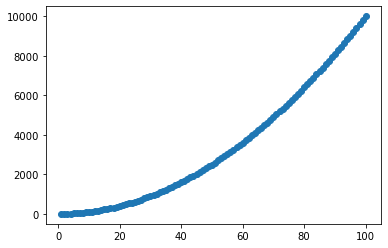

In [ ]:
plt.scatter(x, x_beta)

In [ ]:
# 建立模型 : piecewise
model = Model("model")  # build a new model, name it as "model"

# 設定時間及 gap
model.params.NonConvex = shape_beta
# model.Params.MIPGap = mipgap    # 1%
model.Params.TimeLimit = run_time  # 30 minutes

# 定義決策變數

## maintenance before the i th position or not
y_i = model.addVars(n, vtype=GRB.BINARY)

## the age of machine on the i th position after decide PM
a_before = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)
                       
## the age of machine on the i th position before decide PM
a_after = model.addVars(n, vtype=GRB.CONTINUOUS, lb=1, ub = 100)

## the expected completion time of machine on the i th position
e_i = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0)


## peicewise linearize
u = model.addVars(n, m, lb=0.0, ub=1.0, vtype=GRB.BINARY, name="u")
w = model.addVars(n, m, lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="w")
u_bar = model.addVars(n, m, lb=0.0, ub=1.0, vtype=GRB.BINARY, name="u_bar")
w_bar = model.addVars(n, m, lb=0.0, ub=float('inf'), vtype=GRB.CONTINUOUS, name="w_bar")

# 定義目標變數

model.setObjective((quicksum(w_i[i]*e_i[i] for i in range(n))), GRB.MINIMIZE)

# 定義限制式

# define the completion time of each position
model.addConstr((e_i[0] == 
                 pm_time * y_i[0] + p_i[0] + \
                 cm_time *
                 (
                     (x_beta[0] + slope_s[0] * (a_after[0] - x[0]) + \
                      quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u[0,j] + a_after[0] - x[j] - w[0,j]) for j in range(1, m-1))) - \
                     (x_beta[0] + slope_s[0] * (a_before[0] - x[0]) + \
                      quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u_bar[0,j] + a_before[0] - x[j] - w_bar[0,j]) for j in range(1, m-1)))
                 )/(scale_eta**shape_beta)
                ), "Define first expected completion time")
model.addConstrs(((e_i[i] == e_i[i-1] + \
                   pm_time * y_i[i] + p_i[i] + \
                   cm_time *
                   (
                       (x_beta[0] + slope_s[0] * (a_after[i] - x[0]) + \
                        quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u[i,j] + a_after[i] - x[j] - w[i,j]) for j in range(1, m-1))) - \
                      (x_beta[0] + slope_s[0] * (a_before[i] - x[0]) + \
                        quicksum((slope_s[j] - slope_s[j-1]) * (x[j] * u_bar[i,j] + a_before[i] - x[j] - w_bar[i,j]) for j in range(1, m-1)))
                    )/(scale_eta**shape_beta)
                 ) for i in range(1,n)), "Define expected completion time")

# define the a_after and a_before of each position
M = 100
model.addConstrs((a_before[i] >= a_after[i-1] - M*y_i[i] for i in range(1,n)), "Define a_before")
model.addConstr((a_before[0] >= initial_age - M*y_i[0]), "Define initial a_before")
model.addConstrs((a_after[i] == a_before[i] + p_i[i] for i in range(n)), "Define a_after")

# constraints for a_after term
model.addConstrs(-x[m-1] * u[i,j] <= a_after[i] - x[j] for j in range(1, m) for i in range(n))
model.addConstrs(a_after[i] - x[j] <= x[m-1] * (1 - u[i,j]) for j in range(1, m) for i in range(n))
model.addConstrs(-x[m-1] * u[i,j] <= w[i,j] for j in range(1, m) for i in range(n))
model.addConstrs(w[i,j] <= x[m-1] * u[i,j] for j in range(1, m) for i in range(n))
model.addConstrs(x[m-1] * (u[i,j] - 1) + a_after[i] <= w[i,j] for j in range(1, m) for i in range(n))
model.addConstrs(w[i,j] <= x[m-1] * (1 - u[i,j]) + a_after[i] for j in range(1, m) for i in range(n))
model.addConstrs(u[i,j] >= u[i,j-1] for j in range(1, m) for i in range(n))

# # constraints for a_before term
model.addConstrs(-x[m-1] * u_bar[i,j] <= a_before[i] - x[j] for j in range(1, m) for i in range(n))
model.addConstrs(a_before[i] - x[j] <= x[m-1] * (1 - u_bar[i,j]) for j in range(1, m) for i in range(n))
model.addConstrs(-x[m-1] * u_bar[i,j] <= w_bar[i,j] for j in range(1, m) for i in range(n))
model.addConstrs(w_bar[i,j] <= x[m-1] * u_bar[i,j] for j in range(1, m) for i in range(n))
model.addConstrs(x[m-1] * (u_bar[i,j] - 1) + a_before[i] <= w_bar[i,j] for j in range(1, m) for i in range(n))
model.addConstrs(w_bar[i,j] <= x[m-1] * (1 - u_bar[i,j]) + a_before[i] for j in range(1, m) for i in range(n))
model.addConstrs(u_bar[i,j] >= u_bar[i,j-1] for j in range(1, m) for i in range(n))
# run Gurobi
model.optimize()

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4167 rows, 1212 columns and 10708 nonzeros
Model fingerprint: 0x1651a5ce
Variable types: 609 continuous, 603 integer (603 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [2e+00, 2e+02]
Presolve removed 1663 rows and 371 columns
Presolve time: 0.07s
Presolved: 2504 rows, 841 columns, 6610 nonzeros
Variable types: 421 continuous, 420 integer (420 binary)
Found heuristic solution: objective 430.9210000

Root relaxation: objective 4.124847e+02, 923 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

In [ ]:
# print result - 100
flag = 0
for i in range(n):
    print('y_i',y_i[i].x)
    print('a_i_bar',a_before[i].x)
    print('a_i',a_after[i].x)
    
    if y_i[i].x == 1:
        flag = 1
        print('在第 ' + str(i+1) + ' 個 job 前維修')
if flag == 0:
    print('無插入任何維修')

NameError: name 'n' is not defined